# 0.0 Imports

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import scipy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

import snowflake.connector

from dotenv import load_dotenv
import os
load_dotenv()

True

In [10]:
ACCOUNT_ID = os.getenv("ACCOUNT_ID")
USERNAME = os.getenv("USERNAME")
PASSWORD = os.getenv("PASSWORD")
ROLE = os.getenv("ROLE")
WAREHOUSE = os.getenv("WAREHOUSE")
DATABASE = os.getenv("DATABASE")
SCHEMA = os.getenv("SCHEMA")

In [11]:
def get_fences(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR
    return lower_fence, upper_fence

def calculate_metrics(model_name, y_true, y_pred):
    """
    Calcula métricas de classificação para um modelo.
    
    Parameters:
    -----------
    model_name : str
        Nome do modelo
    y_true : array-like
        Classes reais
    y_pred : array-like
        Classes previstas
        
    Returns:
    --------
    dict
        Dicionário com as métricas: nome do modelo, acurácia, precisão, 
        recall, f1-score, specificity e AUC
    """
    # Calcular matriz de confusão
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calcular métricas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    specificity = tn / (tn + fp)
    auc = roc_auc_score(y_true, y_pred)
    
    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity,
        'auc': auc
    }

In [12]:
conn = snowflake.connector.connect(
    account= ACCOUNT_ID,  
    user= USERNAME,        
    password= PASSWORD,
    role= ROLE,             
    warehouse= WAREHOUSE,     
    database= DATABASE,
    schema= SCHEMA    
)

df_raw = pd.read_sql("SELECT * FROM dados_modelo", conn)
df_raw.head()

/var/folders/77/sv0r0hys7jg3ht7_khjzpp8r0000gn/T/ipykernel_1122/2625306859.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_raw = pd.read_sql("SELECT * FROM dados_modelo", conn)


,AGE,SEX,CHEST_PAIN,TRESTBPS,CHOL,FBS,RESTECG,THALACH,EXANG,OLDPEAK,SLOPE,CA,THAL,HEART_DISEASE
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [13]:
df_raw.shape

(1025, 14)

In [14]:
df_raw.isnull().sum()

AGE              0
SEX              0
CHEST_PAIN       0
TRESTBPS         0
CHOL             0
FBS              0
RESTECG          0
THALACH          0
EXANG            0
OLDPEAK          0
SLOPE            0
CA               0
THAL             0
HEART_DISEASE    0
dtype: int64

In [15]:
df1 = df_raw.copy()

In [16]:
df1.columns = ["age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","target"]

In [17]:
df1["trestbps"].describe()

count    1025.000000
mean      131.611707
std        17.516718
min        94.000000
25%       120.000000
50%       130.000000
75%       140.000000
max       200.000000
Name: trestbps, dtype: float64

In [18]:
px.box(df1, y="trestbps")

In [19]:
lower_limit, upper_limit = get_fences(df1, "trestbps")
lower_limit, upper_limit

(np.float64(90.0), np.float64(170.0))

In [20]:
df1 = df1.loc[(df1["trestbps"] >= lower_limit) & (df1["trestbps"] <= upper_limit+10)]

In [21]:
df1["chol"].describe()

count    1018.000000
mean      245.725933
std        51.662913
min       126.000000
25%       211.000000
50%       240.000000
75%       274.750000
max       564.000000
Name: chol, dtype: float64

In [22]:
lower_limit, upper_limit = get_fences(df1, "chol")
lower_limit, upper_limit

(np.float64(115.375), np.float64(370.375))

In [23]:
px.box(df1, y="chol")

In [24]:
df1 = df1.loc[(df1["chol"] >= lower_limit) & (df1["chol"] <= upper_limit)]

In [25]:
df1["oldpeak"].describe()

count    1002.000000
mean        1.047705
std         1.156185
min         0.000000
25%         0.000000
50%         0.800000
75%         1.750000
max         6.200000
Name: oldpeak, dtype: float64

In [26]:
lower_limit, upper_limit = get_fences(df1, "oldpeak")
lower_limit, upper_limit

(np.float64(-2.625), np.float64(4.375))

In [27]:
px.box(df1, y="oldpeak")

In [28]:
df1.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [29]:
cat_columns = ["cp", "fbs", "restecg", "exang", "slope", "ca", "thal", "target"]
num_columns = ["age", "sex", "trestbps", "chol", "thalach", "oldpeak"]

# 1.0 Visualizações Exploratórias

Antes de fazer o encoding e normalização, vamos explorar visualmente os dados.

In [30]:
# Distribuição da variável alvo
fig = px.pie(df1, names='target', title='Distribuição de Pacientes com/sem Doença Cardíaca',
             labels={'target': 'Target', 0: 'Sem Doença', 1: 'Com Doença'})
fig.update_traces(textinfo='percent+label', pull=[0, 0.1])
fig.show()

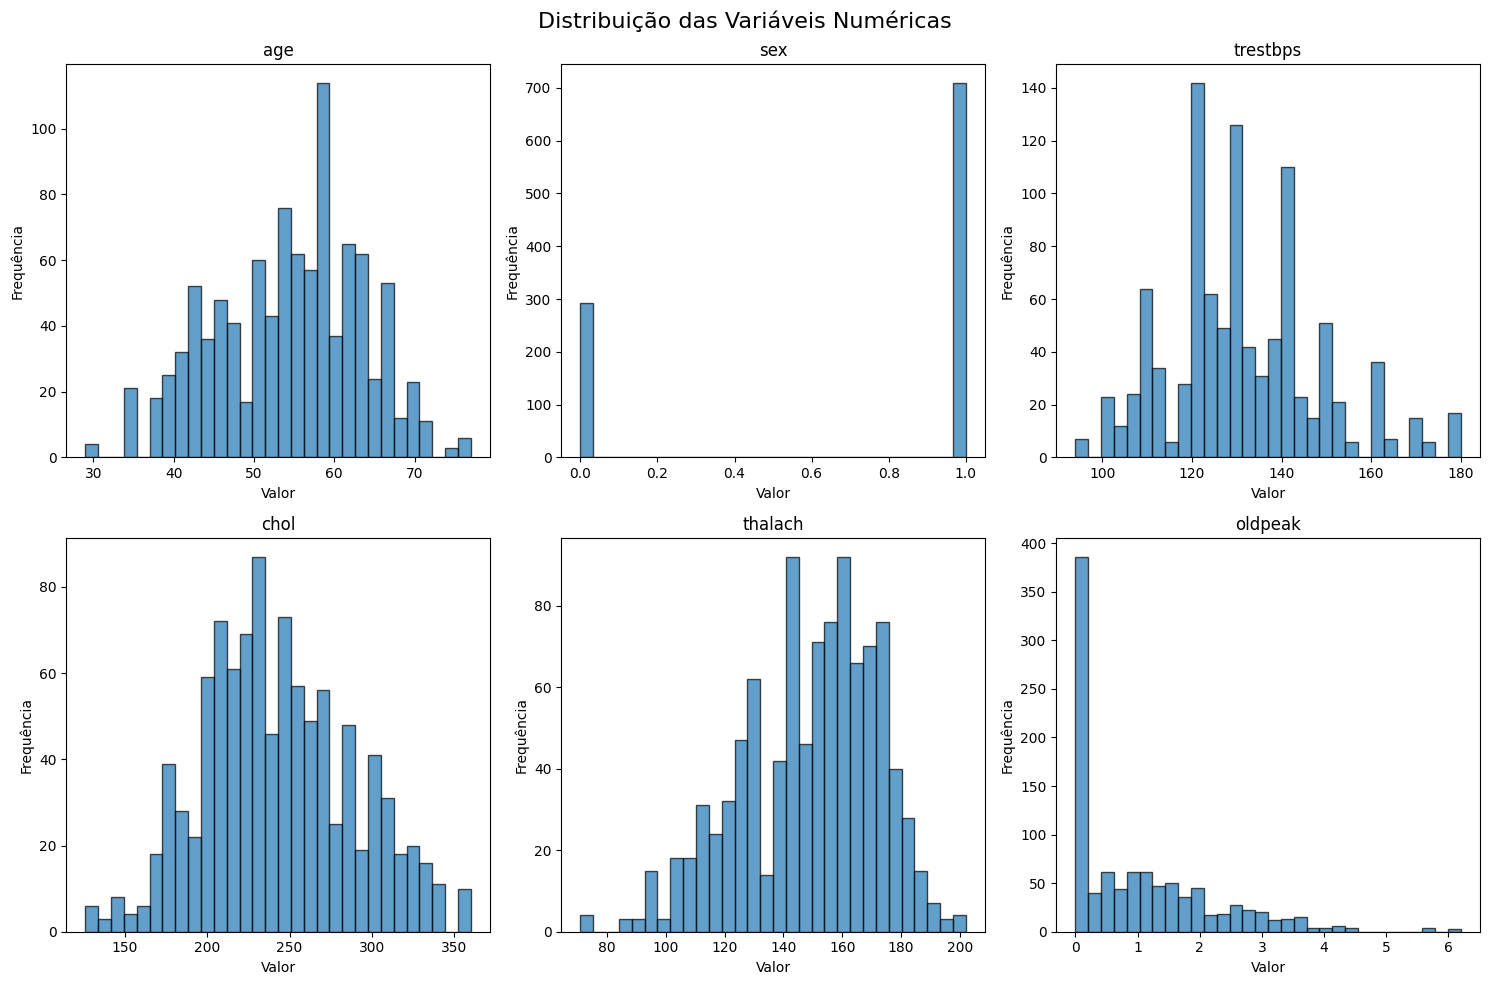

In [31]:
# Distribuição das variáveis numéricas
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribuição das Variáveis Numéricas', fontsize=16)

for idx, col in enumerate(num_columns):
    row = idx // 3
    col_idx = idx % 3
    axes[row, col_idx].hist(df1[col], bins=30, edgecolor='black', alpha=0.7)
    axes[row, col_idx].set_title(col)
    axes[row, col_idx].set_xlabel('Valor')
    axes[row, col_idx].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

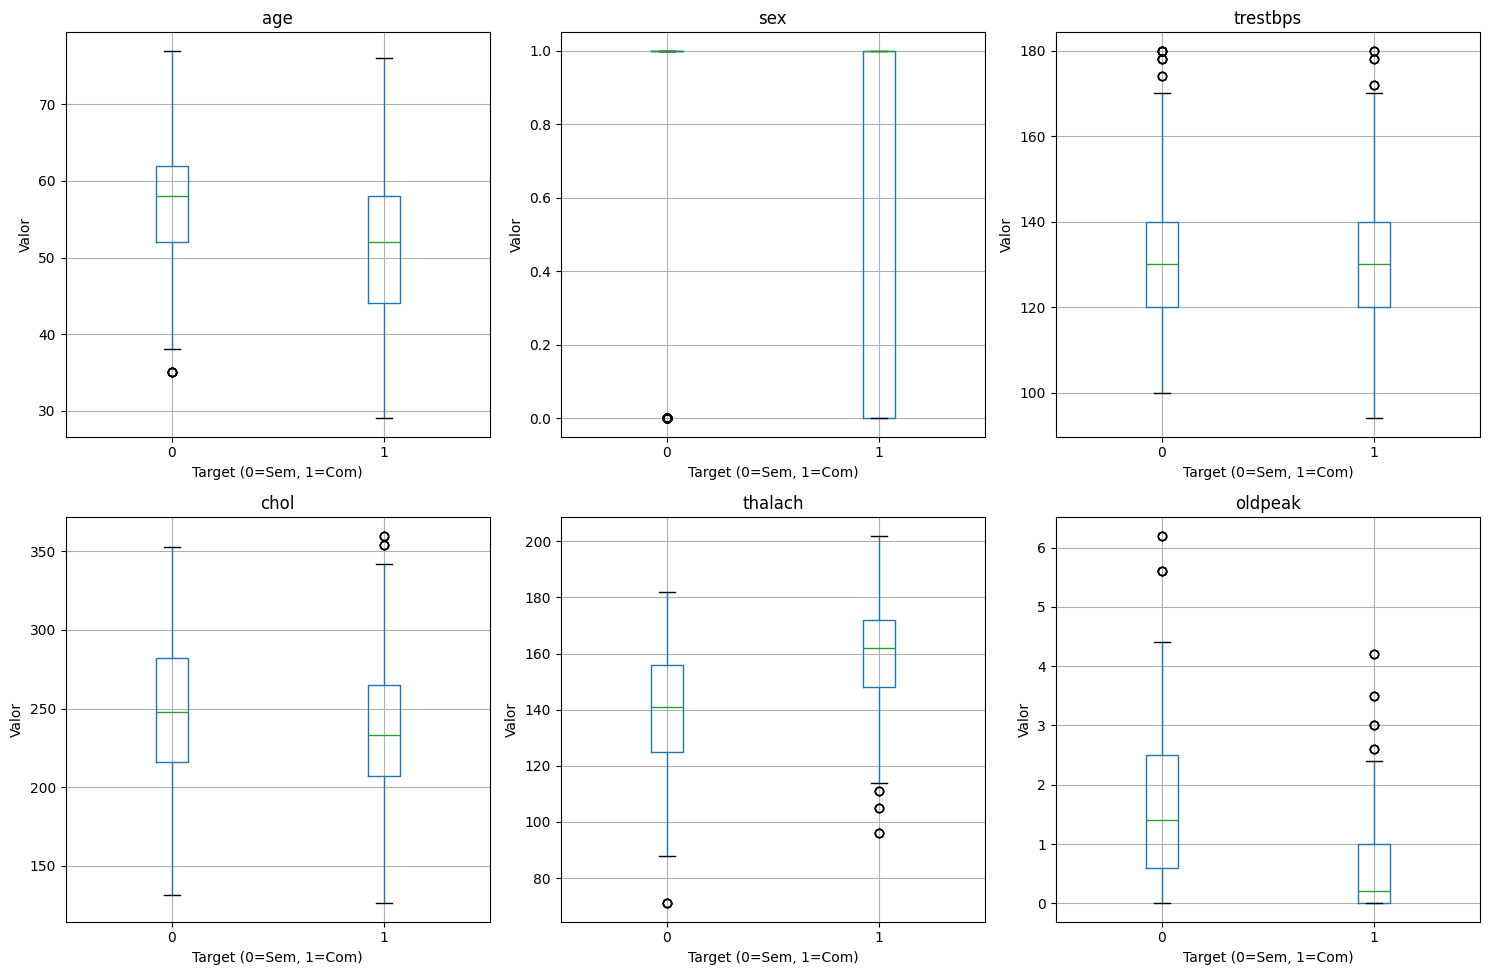

In [32]:
# Boxplots das variáveis numéricas por target
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Boxplots das Variáveis Numéricas por Presença de Doença Cardíaca', fontsize=16)

for idx, col in enumerate(num_columns):
    row = idx // 3
    col_idx = idx % 3
    df1.boxplot(column=col, by='target', ax=axes[row, col_idx])
    axes[row, col_idx].set_title(col)
    axes[row, col_idx].set_xlabel('Target (0=Sem, 1=Com)')
    axes[row, col_idx].set_ylabel('Valor')

plt.suptitle('')  # Remove o título padrão do boxplot
plt.tight_layout()
plt.show()

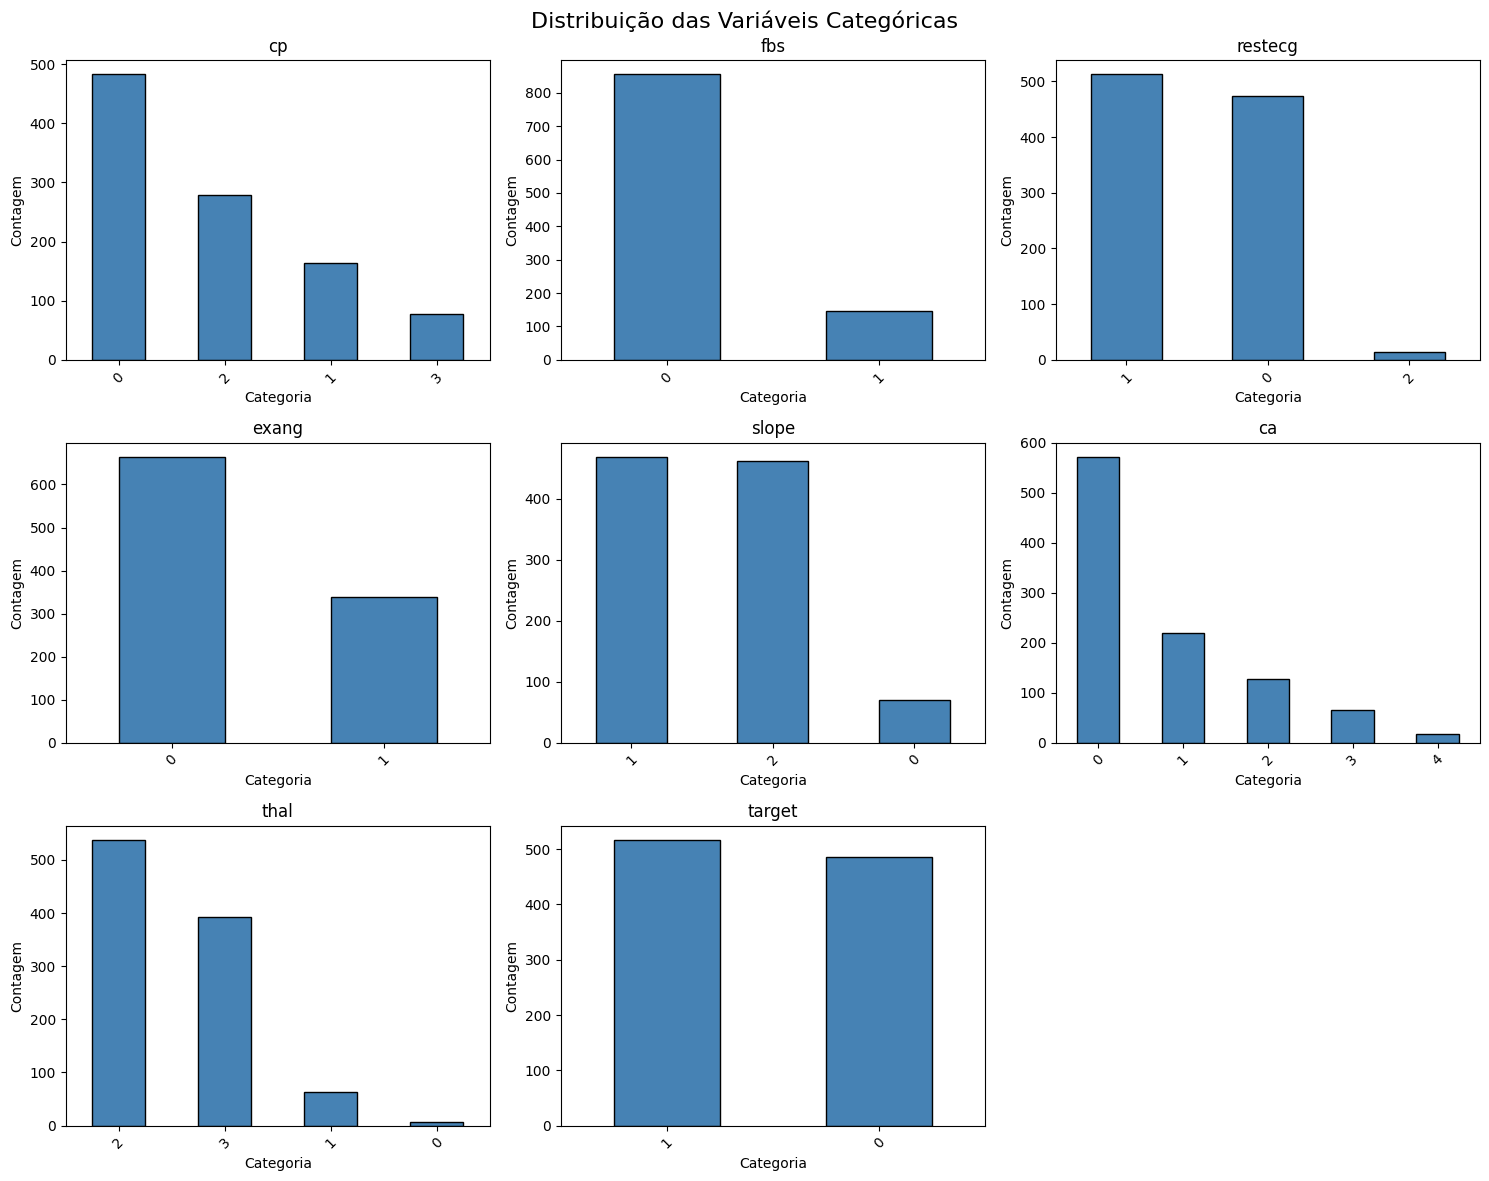

In [33]:
# Distribuição das variáveis categóricas
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Distribuição das Variáveis Categóricas', fontsize=16)

for idx, col in enumerate(cat_columns):
    row = idx // 3
    col_idx = idx % 3
    df1[col].value_counts().plot(kind='bar', ax=axes[row, col_idx], color='steelblue', edgecolor='black')
    axes[row, col_idx].set_title(col)
    axes[row, col_idx].set_xlabel('Categoria')
    axes[row, col_idx].set_ylabel('Contagem')
    axes[row, col_idx].tick_params(axis='x', rotation=45)

# Remover o último subplot se houver menos variáveis que subplots
if len(cat_columns) < 9:
    for idx in range(len(cat_columns), 9):
        row = idx // 3
        col_idx = idx % 3
        fig.delaxes(axes[row, col_idx])

plt.tight_layout()
plt.show()

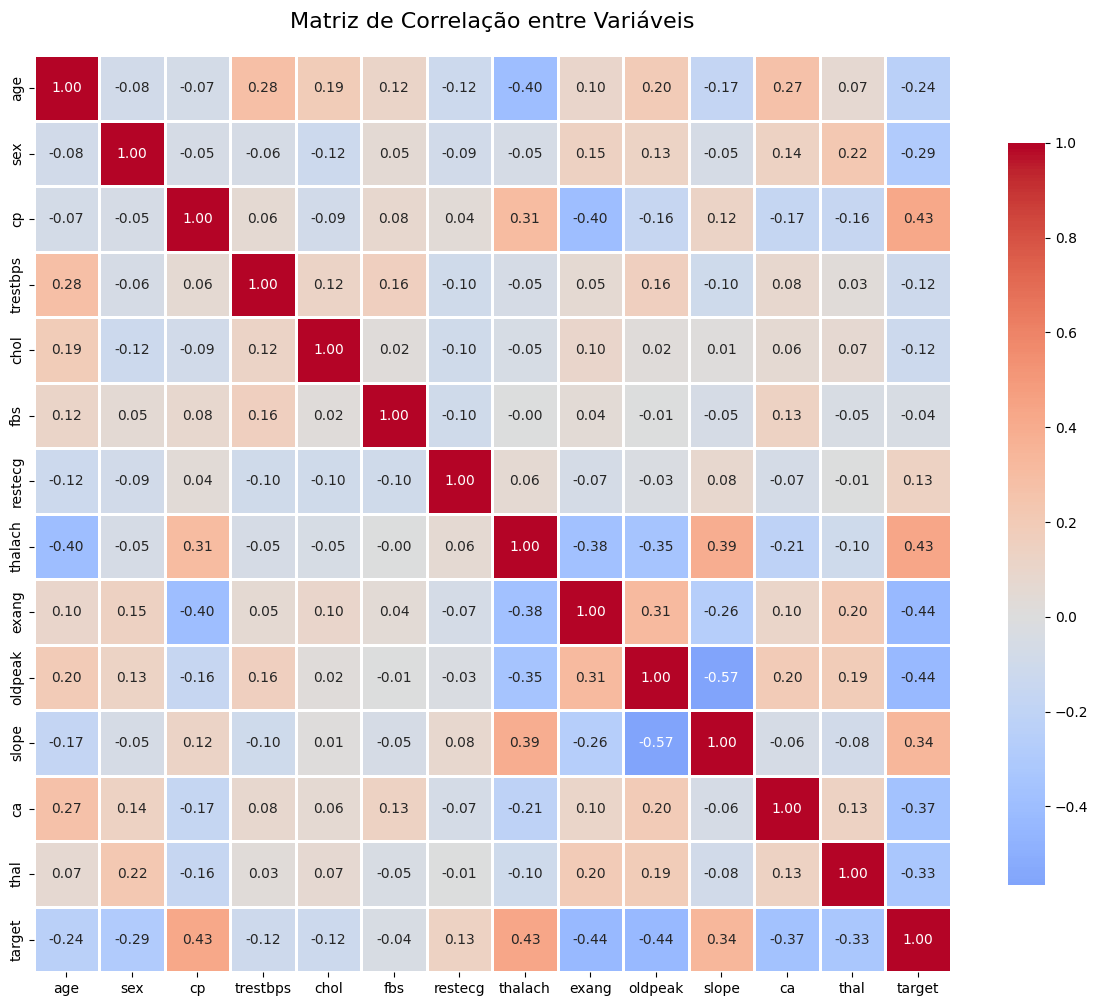

In [34]:
# Matriz de correlação
plt.figure(figsize=(12, 10))
correlation_matrix = df1.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlação entre Variáveis', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

Top correlações com Target:

target      1.000000
thalach     0.431980
cp          0.430353
slope       0.344988
restecg     0.131875
fbs        -0.041497
trestbps   -0.115390
chol       -0.124872
age        -0.238612
sex        -0.291534
thal       -0.329906
ca         -0.370777
oldpeak    -0.436632
exang      -0.436735
Name: target, dtype: float64


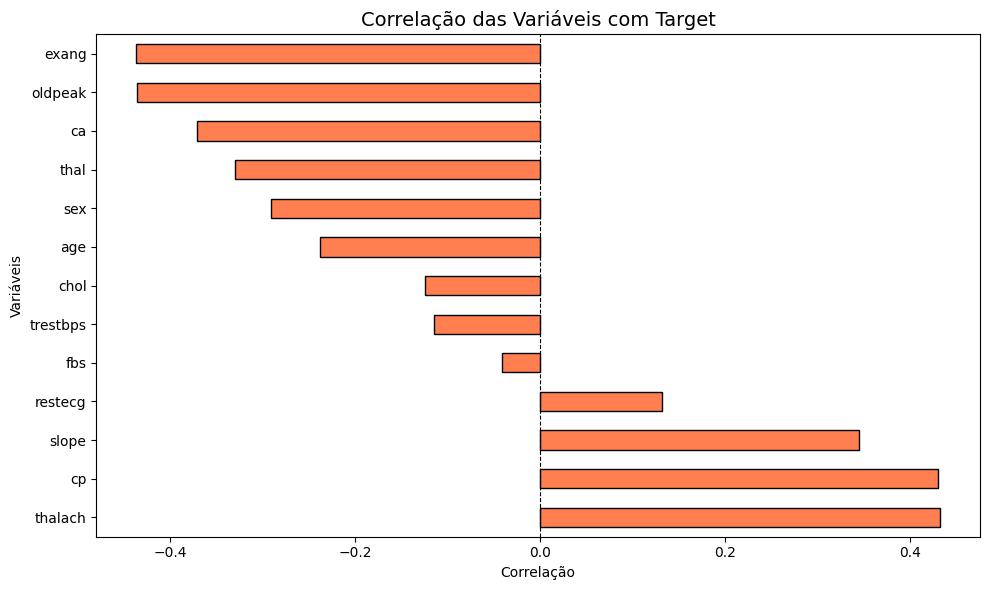

In [35]:
# Top correlações com a variável target
target_corr = correlation_matrix['target'].sort_values(ascending=False)
print("Top correlações com Target:\n")
print(target_corr)

# Visualização das top correlações
plt.figure(figsize=(10, 6))
target_corr.drop('target').plot(kind='barh', color='coral', edgecolor='black')
plt.title('Correlação das Variáveis com Target', fontsize=14)
plt.xlabel('Correlação')
plt.ylabel('Variáveis')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

In [36]:
# Scatter plots interativos das variáveis mais correlacionadas
fig = px.scatter(df1, x='cp', y='thalach', color='target', 
                 title='Relação entre Chest Pain Type e Max Heart Rate por Target',
                 labels={'cp': 'Chest Pain Type', 'thalach': 'Max Heart Rate', 'target': 'Doença Cardíaca'},
                 color_discrete_map={0: 'blue', 1: 'red'},
                 hover_data=['age', 'sex', 'chol'])
fig.show()

In [37]:
# Distribuição de idade por sexo e target
fig = px.violin(df1, x='sex', y='age', color='target', box=True,
                title='Distribuição de Idade por Sexo e Presença de Doença Cardíaca',
                labels={'sex': 'Sexo (0=F, 1=M)', 'age': 'Idade', 'target': 'Doença'},
                color_discrete_map={0: 'lightblue', 1: 'salmon'})
fig.show()

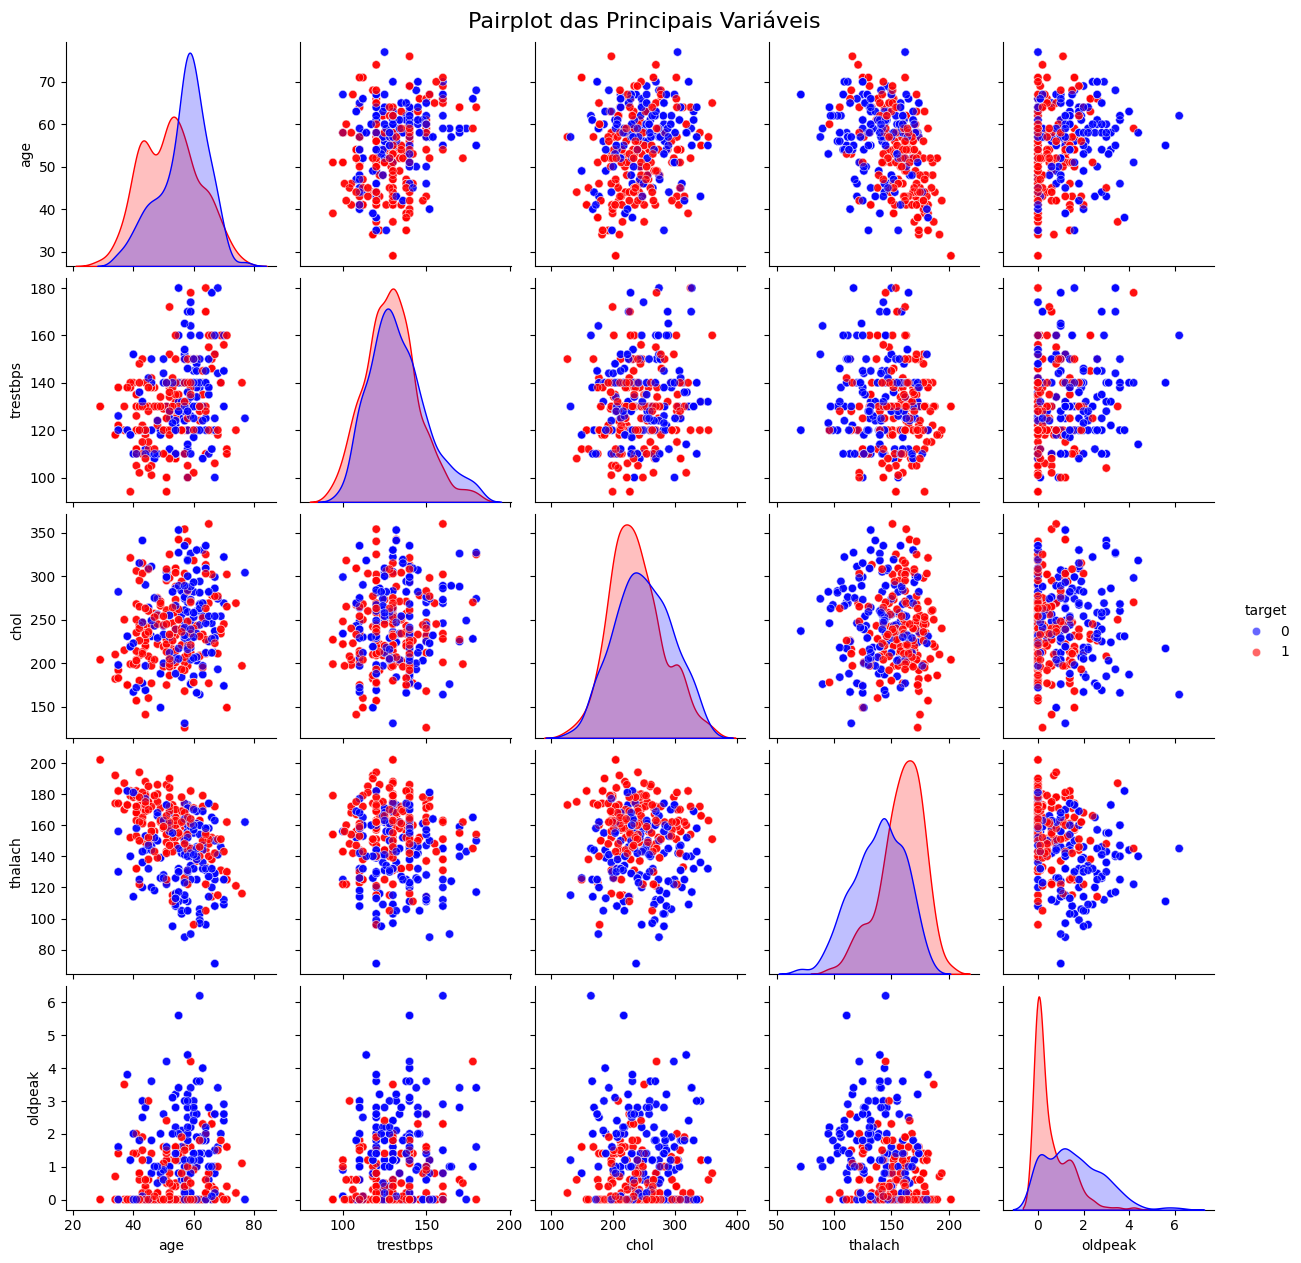

In [38]:
# Pairplot das principais variáveis numéricas
selected_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'target']
sns.pairplot(df1[selected_features], hue='target', palette={0: 'blue', 1: 'red'}, 
             diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Pairplot das Principais Variáveis', y=1.01, fontsize=16)
plt.show()

## Insights das Visualizações

As visualizações acima mostram:

1. **Distribuição Target**: Proporção entre pacientes com e sem doença cardíaca
2. **Variáveis Numéricas**: Como idade, pressão arterial, colesterol, etc. se distribuem
3. **Boxplots por Target**: Diferenças nos valores das variáveis entre grupos com/sem doença
4. **Variáveis Categóricas**: Frequência de cada categoria
5. **Correlações**: Quais variáveis têm maior relação com a presença de doença cardíaca
6. **Scatter e Violin Plots**: Relações multivariadas e distribuições por grupos

In [39]:
scaler = StandardScaler()
df1[num_columns] = scaler.fit_transform(df1[num_columns])
df1.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,-0.252578,0.641301,0,-0.362461,-0.676177,0,1,0.825860,0,-0.041281,2,2,3,0
1,-0.142685,0.641301,0,0.532232,-0.874511,1,0,0.262603,1,1.775945,0,0,3,0
2,1.725490,0.641301,0,0.830463,-1.513586,0,1,-1.037222,1,1.343272,0,0,3,0
3,0.736456,0.641301,0,1.009402,-0.874511,0,1,0.522568,0,-0.906627,2,1,3,0
4,0.846349,-1.559329,0,0.412940,1.130862,1,1,-1.860445,0,0.737530,1,3,2,0


In [40]:
X = df1.drop('target', axis=1)
y = df1['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (701, 13)
X_test shape: (301, 13)
y_train shape: (701,)
y_test shape: (301,)


In [41]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "Gaussian Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

In [42]:
# Definir os grids de hiperparâmetros para cada modelo
param_grids = {
    "Logistic Regression": {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs'],
        'max_iter': [100, 200, 300]
    },
    "Decision Tree": {
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    },
    "Random Forest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "Gradient Boosting": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    },
    "Support Vector Machine": {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    },
    "Gaussian Naive Bayes": {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
    },
    "K-Nearest Neighbors": {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
}

# Executar GridSearchCV para cada modelo
best_models = {}
results = []

for model_name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Treinando: {model_name}")
    print(f"{'='*60}")
    
    # GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    # Treinar
    grid_search.fit(X_train, y_train)
    
    # Salvar melhor modelo
    best_models[model_name] = grid_search.best_estimator_
    
    # Fazer predições
    y_pred = grid_search.best_estimator_.predict(X_test)
    
    # Calcular métricas
    metrics = calculate_metrics(model_name, y_test, y_pred)
    metrics['best_params'] = grid_search.best_params_
    metrics['best_score_cv'] = grid_search.best_score_
    
    results.append(metrics)
    
    print(f"\nMelhores parâmetros: {grid_search.best_params_}")
    print(f"Melhor score CV: {grid_search.best_score_:.4f}")
    print(f"Acurácia no teste: {metrics['accuracy']:.4f}")

# Criar DataFrame com os resultados
df_results = pd.DataFrame(results)
df_results


Treinando: Logistic Regression
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Melhores parâmetros: {'C': 0.01, 'max_iter': 100, 'solver': 'liblinear'}
Melhor score CV: 0.8460
Acurácia no teste: 0.8505

Treinando: Decision Tree
Fitting 5 folds for each of 90 candidates, totalling 450 fits

Melhores parâmetros: {'C': 0.01, 'max_iter': 100, 'solver': 'liblinear'}
Melhor score CV: 0.8460
Acurácia no teste: 0.8505

Treinando: Decision Tree
Fitting 5 folds for each of 90 candidates, totalling 450 fits

Melhores parâmetros: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Melhor score CV: 0.9829
Acurácia no teste: 0.9900

Treinando: Random Forest
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Melhores parâmetros: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Melhor score CV: 0.9829
Acurácia no teste: 0.9900

Treinando: Random Forest
Fitting 5 folds for each of 108 candidates, t

,model,accuracy,precision,recall,f1_score,specificity,auc,best_params,best_score_cv
0,Logistic Regression,0.850498,0.810345,0.921569,0.862385,0.777027,0.849298,"{'C': 0.01, 'max_iter': 100, 'solver': 'liblin...",0.845957
1,Decision Tree,0.990033,1.000000,0.980392,0.990099,1.000000,0.990196,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.982867
2,Random Forest,0.990033,1.000000,0.980392,0.990099,1.000000,0.990196,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.991439
3,Gradient Boosting,0.980066,1.000000,0.960784,0.980000,1.000000,0.980392,"{'learning_rate': 0.2, 'max_depth': 5, 'min_sa...",0.990010
4,Support Vector Machine,0.990033,1.000000,0.980392,0.990099,1.000000,0.990196,"{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",0.980010
5,Gaussian Naive Bayes,0.843854,0.815476,0.895425,0.853583,0.790541,0.842983,{'var_smoothing': 1e-09},0.827366
6,K-Nearest Neighbors,0.990033,1.000000,0.980392,0.990099,1.000000,0.990196,"{'metric': 'manhattan', 'n_neighbors': 7, 'wei...",0.991429


In [43]:
# Executar Cross Validation com os melhores modelos
cv_results = []

for model_name, best_model in best_models.items():
    print(f"\n{'='*60}")
    print(f"Cross Validation: {model_name}")
    print(f"{'='*60}")
    
    # Fazer predições com cross validation
    y_pred_cv = cross_val_predict(best_model, X_train, y_train, cv=5)
    
    # Calcular métricas
    metrics = calculate_metrics(model_name, y_train, y_pred_cv)
    
    # Calcular scores individuais de cada fold
    accuracy_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
    precision_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='precision')
    recall_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='recall')
    f1_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1')
    
    # Adicionar estatísticas dos folds
    metrics['accuracy_mean_cv'] = accuracy_scores.mean()
    metrics['accuracy_std_cv'] = accuracy_scores.std()
    metrics['precision_mean_cv'] = precision_scores.mean()
    metrics['precision_std_cv'] = precision_scores.std()
    metrics['recall_mean_cv'] = recall_scores.mean()
    metrics['recall_std_cv'] = recall_scores.std()
    metrics['f1_mean_cv'] = f1_scores.mean()
    metrics['f1_std_cv'] = f1_scores.std()
    
    cv_results.append(metrics)
    
    print(f"Accuracy CV: {accuracy_scores.mean():.4f} (+/- {accuracy_scores.std():.4f})")
    print(f"Precision CV: {precision_scores.mean():.4f} (+/- {precision_scores.std():.4f})")
    print(f"Recall CV: {recall_scores.mean():.4f} (+/- {recall_scores.std():.4f})")
    print(f"F1-Score CV: {f1_scores.mean():.4f} (+/- {f1_scores.std():.4f})")

# Criar DataFrame com os resultados do CV
df_cv_results = pd.DataFrame(cv_results)
df_cv_results


Cross Validation: Logistic Regression
Accuracy CV: 0.8460 (+/- 0.0359)
Precision CV: 0.8151 (+/- 0.0500)
Recall CV: 0.9148 (+/- 0.0134)
F1-Score CV: 0.8612 (+/- 0.0289)

Cross Validation: Decision Tree
Accuracy CV: 0.9800 (+/- 0.0114)
Precision CV: 0.9807 (+/- 0.0140)
Recall CV: 0.9752 (+/- 0.0161)
F1-Score CV: 0.9823 (+/- 0.0127)

Cross Validation: Random Forest
Accuracy CV: 0.9800 (+/- 0.0114)
Precision CV: 0.9807 (+/- 0.0140)
Recall CV: 0.9752 (+/- 0.0161)
F1-Score CV: 0.9823 (+/- 0.0127)

Cross Validation: Random Forest
Accuracy CV: 0.9900 (+/- 0.0073)
Precision CV: 0.9864 (+/- 0.0122)
Recall CV: 0.9945 (+/- 0.0068)
F1-Score CV: 0.9904 (+/- 0.0082)

Cross Validation: Gradient Boosting
Accuracy CV: 0.9900 (+/- 0.0073)
Precision CV: 0.9864 (+/- 0.0122)
Recall CV: 0.9945 (+/- 0.0068)
F1-Score CV: 0.9904 (+/- 0.0082)

Cross Validation: Gradient Boosting
Accuracy CV: 0.9900 (+/- 0.0107)
Precision CV: 0.9864 (+/- 0.0172)
Recall CV: 0.9863 (+/- 0.0123)
F1-Score CV: 0.9904 (+/- 0.0103)

C

,model,accuracy,precision,recall,f1_score,specificity,auc,accuracy_mean_cv,accuracy_std_cv,precision_mean_cv,precision_std_cv,recall_mean_cv,recall_std_cv,f1_mean_cv,f1_std_cv
0,Logistic Regression,0.845934,0.812195,0.914835,0.860465,0.771513,0.843174,0.845957,0.035915,0.815059,0.050011,0.914840,0.013383,0.861225,0.028892
1,Decision Tree,0.980029,0.986111,0.975275,0.980663,0.985163,0.980219,0.980030,0.011425,0.980745,0.014016,0.975228,0.016094,0.982256,0.012712
2,Random Forest,0.987161,0.986301,0.989011,0.987654,0.985163,0.987087,0.990010,0.007288,0.986375,0.012170,0.994482,0.006758,0.990420,0.008239
3,Gradient Boosting,0.988588,0.986339,0.991758,0.989041,0.985163,0.988461,0.990000,0.010690,0.986412,0.017152,0.986263,0.012253,0.990363,0.010264
4,Support Vector Machine,0.980029,0.983425,0.978022,0.980716,0.982196,0.980109,0.980010,0.009490,0.983994,0.021165,0.978044,0.010931,0.980798,0.008844
5,Gaussian Naive Bayes,0.827389,0.802993,0.884615,0.841830,0.765579,0.825097,0.827366,0.025456,0.803553,0.029450,0.884551,0.014575,0.841970,0.021956
6,K-Nearest Neighbors,0.991441,0.989071,0.994505,0.991781,0.988131,0.991318,0.991429,0.008330,0.989187,0.013245,0.994482,0.006758,0.991780,0.008005


In [44]:
df_results["best_params"][6]

{'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}

In [45]:
df_results

,model,accuracy,precision,recall,f1_score,specificity,auc,best_params,best_score_cv
0,Logistic Regression,0.850498,0.810345,0.921569,0.862385,0.777027,0.849298,"{'C': 0.01, 'max_iter': 100, 'solver': 'liblin...",0.845957
1,Decision Tree,0.990033,1.000000,0.980392,0.990099,1.000000,0.990196,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.982867
2,Random Forest,0.990033,1.000000,0.980392,0.990099,1.000000,0.990196,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.991439
3,Gradient Boosting,0.980066,1.000000,0.960784,0.980000,1.000000,0.980392,"{'learning_rate': 0.2, 'max_depth': 5, 'min_sa...",0.990010
4,Support Vector Machine,0.990033,1.000000,0.980392,0.990099,1.000000,0.990196,"{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",0.980010
5,Gaussian Naive Bayes,0.843854,0.815476,0.895425,0.853583,0.790541,0.842983,{'var_smoothing': 1e-09},0.827366
6,K-Nearest Neighbors,0.990033,1.000000,0.980392,0.990099,1.000000,0.990196,"{'metric': 'manhattan', 'n_neighbors': 7, 'wei...",0.991429
